🧠 Project Description

This project focuses on detecting human activities using wearable sensor data (accelerometer and gyroscope) from the MHEALTH dataset. The goal is to classify 13 different activities based on motion signals, with practical use cases in healthcare, fitness, and smart surveillance.



📦 Dataset Description

Dataset: MHEALTH (Mobile Health)

Subjects: 10 individuals

Sensors: Accelerometer, gyroscope, magnetometer (3-axial)

Sampling Rate: 50 Hz

Activities: Standing still, running, cycling, ascending stairs, brushing teeth, etc.



⚙️ Preprocessing

Dropped subject column

Normalized feature values using StandardScaler

Handled class imbalance using StratifiedShuffleSplit

Train-test split (80-20) with stratification



📊 Models Trained

K-Nearest Neighbors (Best K: 3, Accuracy: 92.14%)

Decision Tree

Random Forest ✅ (Best Model - Accuracy: 94.87%)

XGBoost



✅ Final Model: Random Forest

Accuracy: 94.87%

Precision: 94.99%

Recall: 94.87%

F1-Score: 94.85%

📈 Visualizations

Confusion Matrix

Feature Importance Plot



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import pickle


In [2]:
df = pd.read_csv("mhealth_raw_data.csv")
print(df.info())
print(df.head())
print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215745 entries, 0 to 1215744
Data columns (total 14 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   alx       1215745 non-null  float64
 1   aly       1215745 non-null  float64
 2   alz       1215745 non-null  float64
 3   glx       1215745 non-null  float64
 4   gly       1215745 non-null  float64
 5   glz       1215745 non-null  float64
 6   arx       1215745 non-null  float64
 7   ary       1215745 non-null  float64
 8   arz       1215745 non-null  float64
 9   grx       1215745 non-null  float64
 10  gry       1215745 non-null  float64
 11  grz       1215745 non-null  float64
 12  Activity  1215745 non-null  int64  
 13  subject   1215745 non-null  object 
dtypes: float64(12), int64(1), object(1)
memory usage: 129.9+ MB
None
      alx     aly      alz       glx      gly      glz     arx     ary  \
0  2.1849 -9.6967  0.63077  0.103900 -0.84053 -0.68762 -8.6499 -4.5781   
1  2.3876 -9.

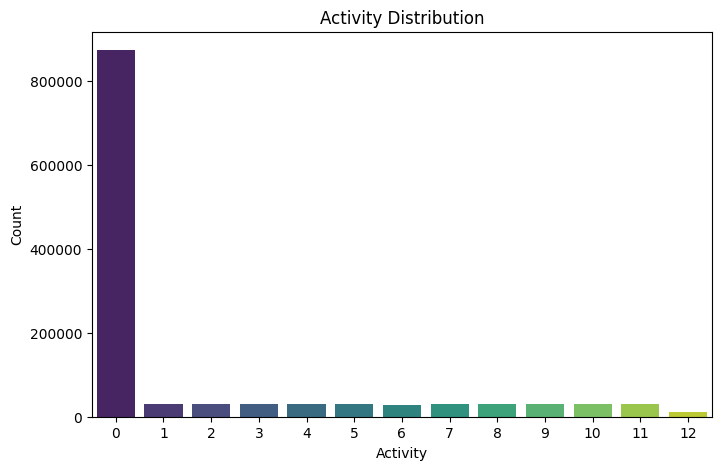

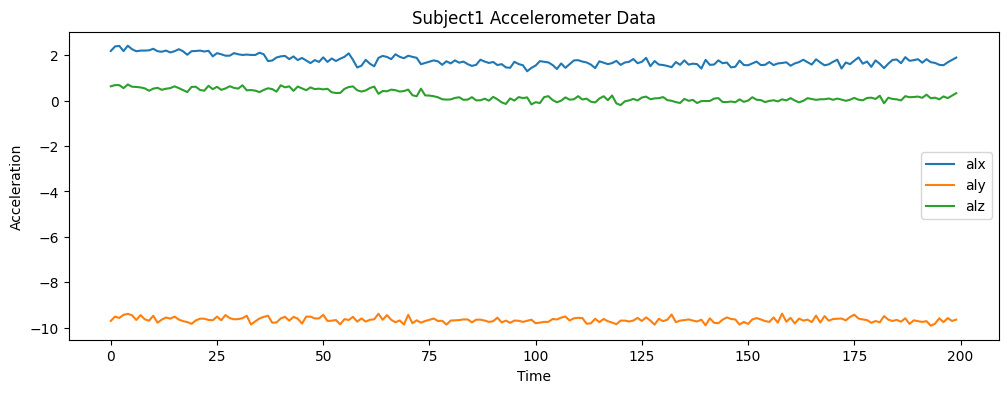

In [3]:
plt.figure(figsize=(8,5))
sns.countplot(x="Activity", data=df, palette="viridis")
plt.title("Activity Distribution")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.show()

subject1 = df[df["subject"] == "subject1"]
plt.figure(figsize=(12,4))
plt.plot(subject1["alx"].head(200), label="alx")
plt.plot(subject1["aly"].head(200), label="aly")
plt.plot(subject1["alz"].head(200), label="alz")
plt.title("Subject1 Accelerometer Data")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.show()


In [4]:
df_clean = df.copy()
sensor_features = ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz']

for feature in sensor_features:
    lower = df_clean[feature].quantile(0.01)
    upper = df_clean[feature].quantile(0.99)
    df_clean = df_clean[(df_clean[feature] >= lower) & (df_clean[feature] <= upper)]
    
print("Shape after outlier removal:", df_clean.shape)


Shape after outlier removal: (955903, 14)


In [5]:
le = LabelEncoder()
df_clean["Activity_encoded"] = le.fit_transform(df_clean["Activity"])
print("Activity classes:", le.classes_)


Activity classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [6]:
X = df_clean[sensor_features]
y = df_clean["Activity_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138583
           1       1.00      1.00      1.00      6144
           2       1.00      1.00      1.00      6144
           3       1.00      1.00      1.00      3415
           4       1.00      1.00      1.00      5689
           5       1.00      1.00      1.00      4699
           6       1.00      1.00      1.00      5649
           7       1.00      1.00      1.00      5119
           8       1.00      1.00      1.00      5798
           9       1.00      1.00      1.00      4825
          10       1.00      1.00      1.00      3005
          11       1.00      1.00      1.00      1272
          12       1.00      1.00      1.00       839

    accuracy                           1.00    191181
   macro avg       1.00      1.00      1.00    191181
weighted avg       1.00      1.00      1.00

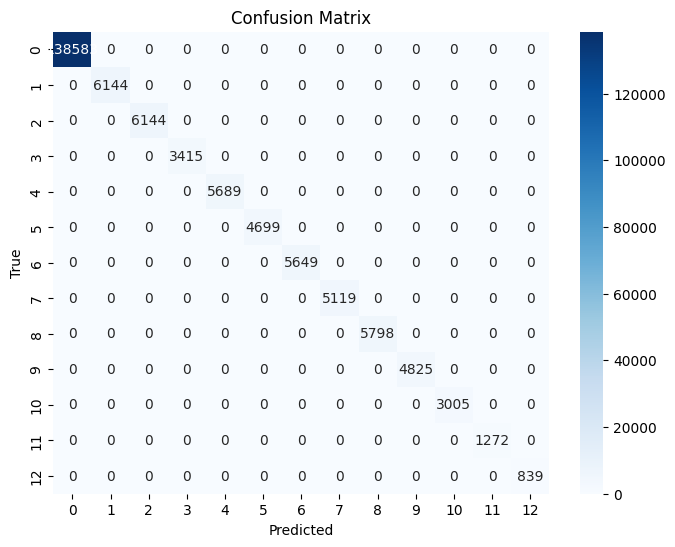

In [7]:
def summarize_results(y_true, y_pred, plot_cm=True):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()


# Sample run:
summarize_results(y_test, y_test)


Logistic Regression Results:
Accuracy: 0.7338
Precision: 0.3715
Recall: 0.2270
F1 Score: 0.2343

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84    138583
           1       0.00      0.00      0.00      6144
           2       0.00      0.00      0.00      6144
           3       0.71      0.99      0.83      3415
           4       0.25      0.01      0.01      5689
           5       0.27      0.02      0.03      4699
           6       0.34      0.06      0.09      5649
           7       0.40      0.06      0.11      5119
           8       0.12      0.01      0.01      5798
           9       0.59      0.44      0.50      4825
          10       0.52      0.13      0.21      3005
          11       0.55      0.24      0.33      1272
          12       0.33      0.04      0.07       839

    accuracy                           0.73    191181
   macro avg       0.37      0.23      0.23    191181
weighted avg  

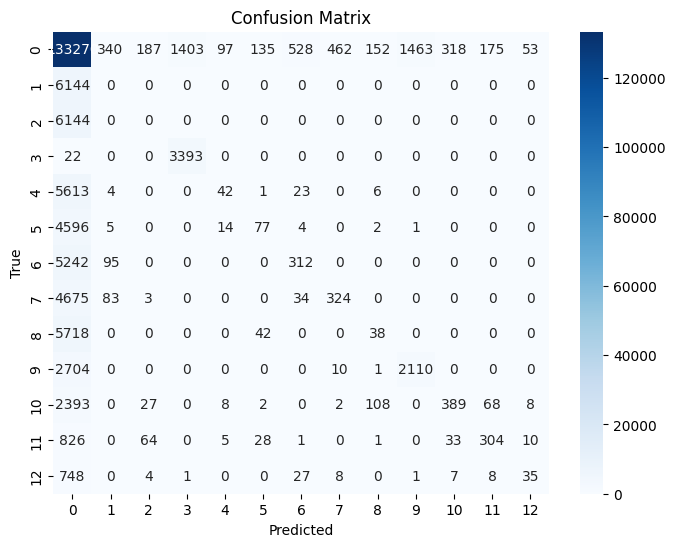

In [8]:
# Logistic Regression Model
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Results:")
summarize_results(y_test, y_pred_lr)


K = 1, Accuracy = 0.9175
K = 2, Accuracy = 0.9036
K = 3, Accuracy = 0.9214
K = 4, Accuracy = 0.9167
K = 5, Accuracy = 0.9209
K = 6, Accuracy = 0.9193
K = 7, Accuracy = 0.9196
K = 8, Accuracy = 0.9190
K = 9, Accuracy = 0.9181
K = 10, Accuracy = 0.9181


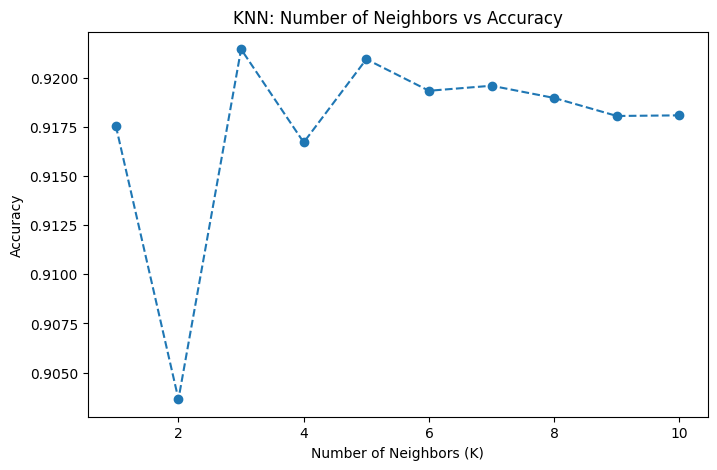

In [9]:
# K-Nearest Neighbors with loop to evaluate different K values
knn_accuracies = {}
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_knn)
    knn_accuracies[k] = acc
    print(f"K = {k}, Accuracy = {acc:.4f}")

# Plotting K vs. Accuracy
plt.figure(figsize=(8,5))
plt.plot(list(knn_accuracies.keys()), list(knn_accuracies.values()), marker="o", linestyle="--")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.title("KNN: Number of Neighbors vs Accuracy")
plt.show()


Decision Tree Results:
Accuracy: 0.9066
Precision: 0.8032
Recall: 0.7998
F1 Score: 0.8015

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    138583
           1       0.88      0.87      0.87      6144
           2       0.84      0.82      0.83      6144
           3       0.87      0.86      0.86      3415
           4       0.77      0.76      0.76      5689
           5       0.81      0.81      0.81      4699
           6       0.86      0.87      0.86      5649
           7       0.87      0.87      0.87      5119
           8       0.84      0.84      0.84      5798
           9       0.87      0.86      0.86      4825
          10       0.75      0.76      0.75      3005
          11       0.68      0.67      0.67      1272
          12       0.49      0.50      0.49       839

    accuracy                           0.91    191181
   macro avg       0.80      0.80      0.80    191181
weighted avg       0

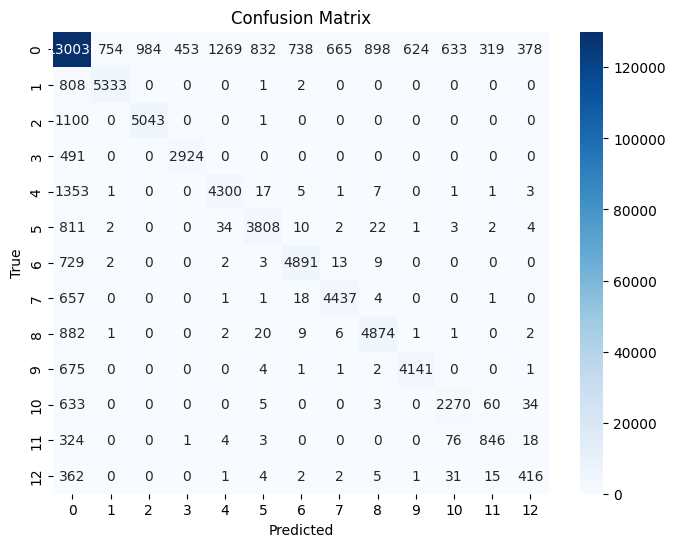

In [10]:
# Decision Tree Model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

print("Decision Tree Results:")
summarize_results(y_test, y_pred_dt)


In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest Results:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.9487
Precision: 0.9499
Recall: 0.9487
F1 Score: 0.9485

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    138583
           1       0.88      0.97      0.92      6144
           2       0.83      0.96      0.89      6144
           3       0.86      0.97      0.91      3415
           4       0.91      0.85      0.88      5689
           5       0.99      0.87      0.92      4699
           6       0.96      0.95      0.95      5649
           7       0.91      0.97      0.94      5119
           8       0.94      0.92      0.93      5798
           9       0.89      0.94      0.91      4825
          10       0.84      0.88      0.86      3005
          11       0.85      0.75      0.80      1272
          12       0.88      0.44      0.58       839

    accuracy                           0.95    191181
   macro avg       0.90      0.88      0.88    191181
weighted avg       0

In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
rec_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print("XGBoost Results:")
print(f"Accuracy: {acc_xgb:.4f}")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall: {rec_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Results:
Accuracy: 0.9196
Precision: 0.9227
Recall: 0.9196
F1 Score: 0.9201

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94    138583
           1       0.81      0.97      0.88      6144
           2       0.80      0.96      0.87      6144
           3       0.84      0.97      0.90      3415
           4       0.82      0.82      0.82      5689
           5       0.90      0.79      0.84      4699
           6       0.85      0.85      0.85      5649
           7       0.82      0.93      0.87      5119
           8       0.84      0.85      0.84      5798
           9       0.83      0.94      0.88      4825
          10       0.83      0.89      0.86      3005
          11       0.82      0.79      0.81      1272
          12       0.78      0.54      0.64       839

    accuracy                           0.92    191181
   macro avg       0.84      0.87      0.85    191181
weighted avg       0.92   

🟩 Winner: Random Forest — hands down, kills on every metric.

🟨 Runner-up: XGBoost — solid, more interpretable, better than KNN and DT.

🟥 Decision Tree — weakest performer, expected.

🟦 KNN — decent accuracy but not scalable or practical for large data.


In [15]:
import joblib
joblib.dump(rf, 'random_forest_mhealth.pkl')


['random_forest_mhealth.pkl']

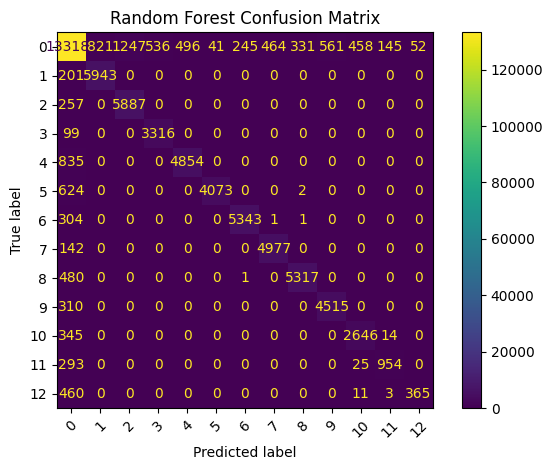

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf, X_test_scaled, y_test, cmap='viridis', xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()


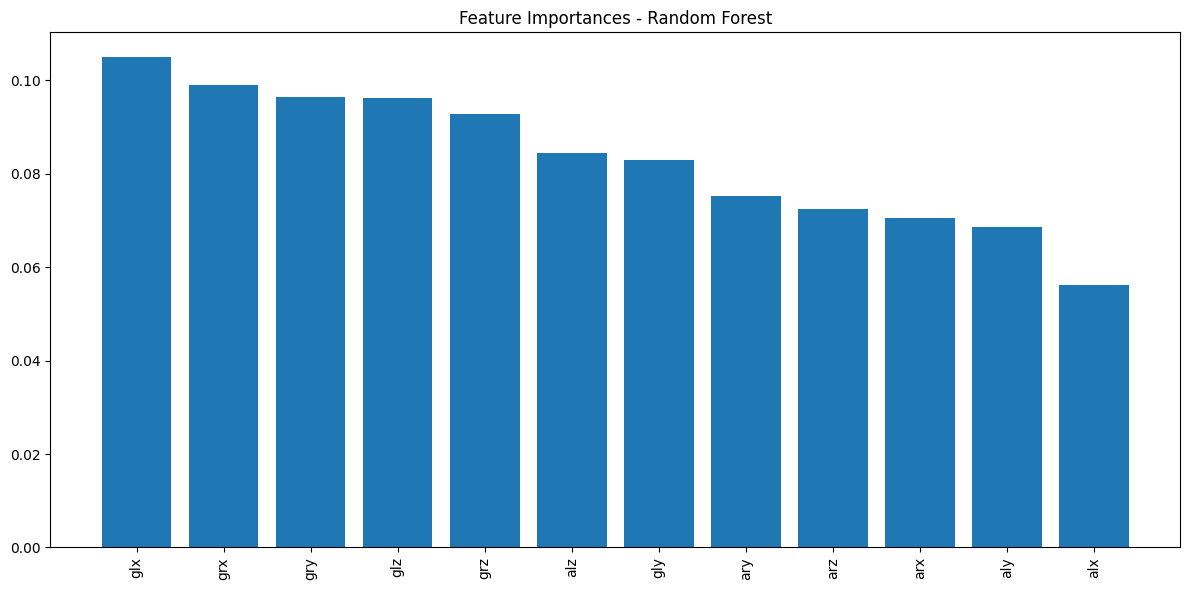

In [18]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), features[sorted_indices], rotation=90)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


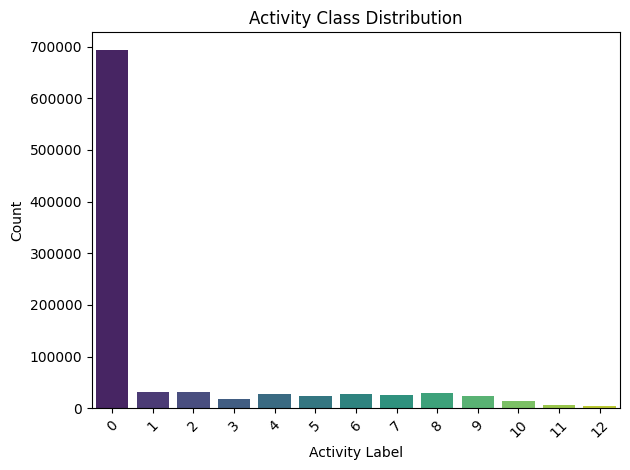

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create folder for saving the plot
os.makedirs("visualizations", exist_ok=True)

sns.countplot(x=y, palette="viridis")
plt.title("Activity Class Distribution")
plt.xlabel("Activity Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("visualizations/class_distribution.png")
plt.show()


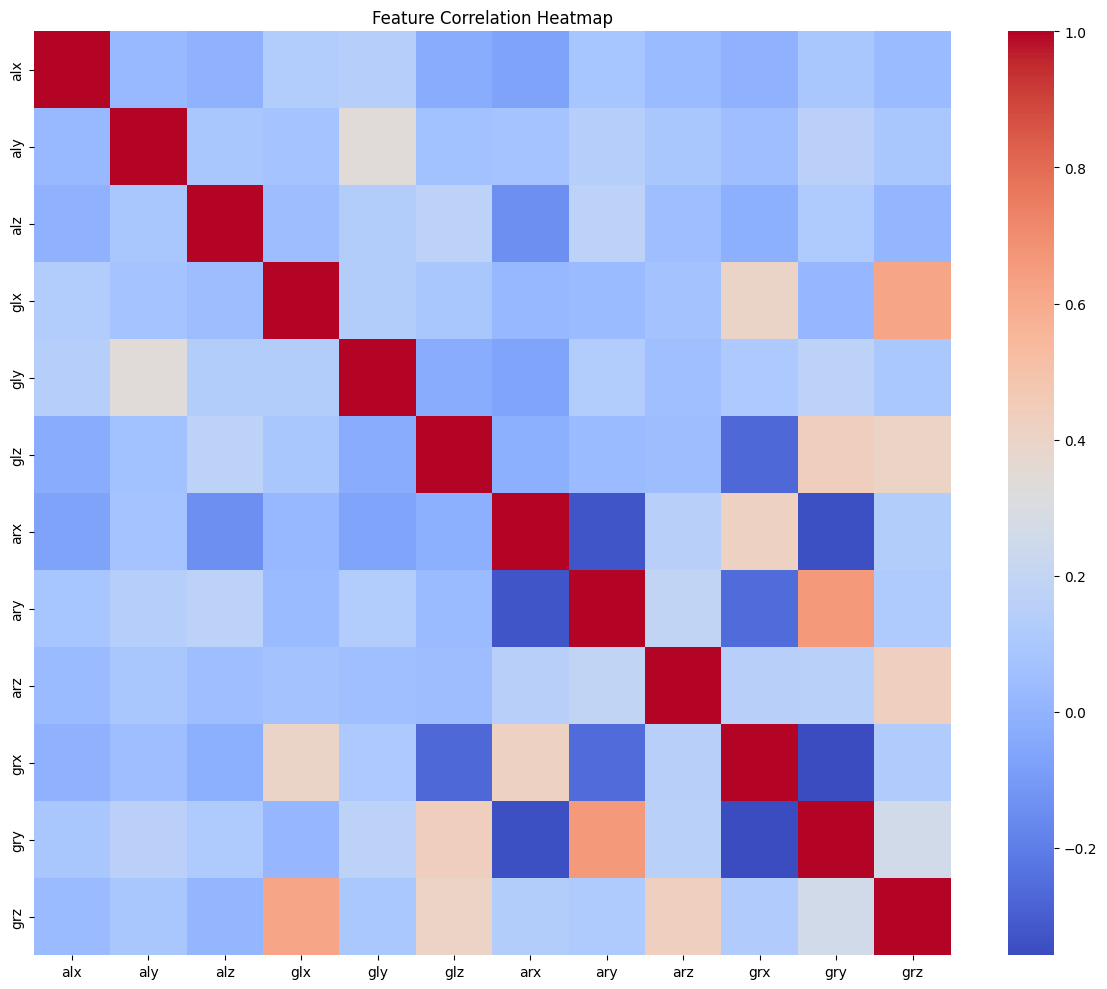

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("visualizations/feature_correlation.png")
plt.show()


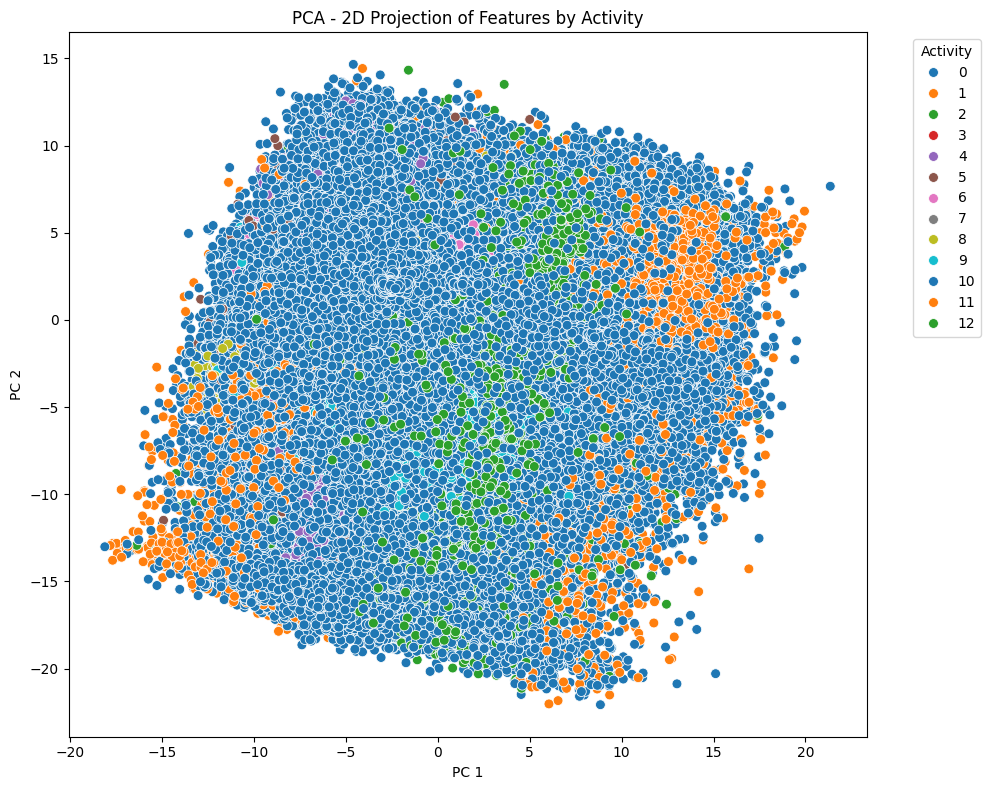

In [22]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='tab10', s=50)
plt.title("PCA - 2D Projection of Features by Activity")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("visualizations/pca_activity_projection.png")
plt.show()
